In [100]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas.tseries.offsets import DateOffset
from pmdarima.arima import auto_arima
#from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [101]:
data = pd.read_csv('AirQualityUCI.csv')
print(data.head())

         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10-03-2004  18:00:00     2.6       1360.0     150.0      11.9   
1  10-03-2004  19:00:00     2.0       1292.0     112.0       9.4   
2  10-03-2004  20:00:00     2.2       1402.0      88.0       9.0   
3  10-03-2004  21:00:00     2.2       1376.0      80.0       9.2   
4  10-03-2004  22:00:00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15  Unnamed: 16  
0  13.6  48.9  0.7578          NaN          NaN  
1  13.3  47.7  0

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


In [103]:
data = data.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)

In [104]:
data.isnull().sum()

Date             114
Time             114
CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
dtype: int64

In [105]:
data.tail(115)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9356,04-04-2005,14:00:00,2.2,1071.0,-200.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028
9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
null_data = data[data.isnull().any(axis=1)]
null_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
data = data.dropna()
data.shape

(9357, 15)

In [108]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [109]:
data = data.replace(-200, np.nan)
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [111]:
data.isnull().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [112]:
data['Date'] = pd.to_datetime(data['Date'],dayfirst=True)

In [113]:
print(data.head())

        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0 2004-03-10  18:00:00     2.6       1360.0     150.0      11.9   
1 2004-03-10  19:00:00     2.0       1292.0     112.0       9.4   
2 2004-03-10  20:00:00     2.2       1402.0      88.0       9.0   
3 2004-03-10  21:00:00     2.2       1376.0      80.0       9.2   
4 2004-03-10  22:00:00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4 

In [114]:
h = data['Time'].tolist()
l=[]
for i in range(len(h)):
    l.append(h[i].split(":")[0])
data['hour']=l

In [115]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

In [116]:
data

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2004,3,10
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2004,3,10
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2004,3,10
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2004,3,10
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2004,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,10,2005,4,4
9353,2005-04-04,11:00:00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,11,2005,4,4
9354,2005-04-04,12:00:00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,12,2005,4,4
9355,2005-04-04,13:00:00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,13,2005,4,4


In [117]:
cols=["year","month","day","hour"]
data['date'] = data[cols].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")
data

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day,date
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2004,3,10,2004/3/10/18
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2004,3,10,2004/3/10/19
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2004,3,10,2004/3/10/20
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2004,3,10,2004/3/10/21
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2004,3,10,2004/3/10/22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,10,2005,4,4,2005/4/4/10
9353,2005-04-04,11:00:00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,11,2005,4,4,2005/4/4/11
9354,2005-04-04,12:00:00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,12,2005,4,4,2005/4/4/12
9355,2005-04-04,13:00:00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,13,2005,4,4,2005/4/4/13


In [118]:
	
data['date']=pd.to_datetime(data['date'])

In [119]:
print(data.to_string())

           Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH hour  year  month  day                date
0    2004-03-10  18:00:00     2.6       1360.0     150.0      11.9         1046.0    166.0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578   18  2004      3   10 2004-03-10 18:00:00
1    2004-03-10  19:00:00     2.0       1292.0     112.0       9.4          955.0    103.0        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255   19  2004      3   10 2004-03-10 19:00:00
2    2004-03-10  20:00:00     2.2       1402.0      88.0       9.0          939.0    131.0        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502   20  2004      3   10 2004-03-10 20:00:00
3    2004-03-10  21:00:00     2.2       1376.0      80.0       9.2          948.0    172.0        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867   21  2004      3   10 

In [120]:
data = data.drop('Date', axis=1)
data = data.drop('Time', axis=1)
data

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day,date
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2004,3,10,2004-03-10 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2004,3,10,2004-03-10 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2004,3,10,2004-03-10 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2004,3,10,2004-03-10 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2004,3,10,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,10,2005,4,4,2005-04-04 10:00:00
9353,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,11,2005,4,4,2005-04-04 11:00:00
9354,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,12,2005,4,4,2005-04-04 12:00:00
9355,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,13,2005,4,4,2005-04-04 13:00:00


In [121]:
df = data.set_index(['date'])
df.head(5)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
date,,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2004,3,10
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2004,3,10
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2004,3,10
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2004,3,10
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2004,3,10


In [122]:
df.dtypes

CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
hour              object
year               int64
month              int64
day                int64
dtype: object

In [123]:
df.isnull().sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
hour                0
year                0
month               0
day                 0
dtype: int64

In [124]:
del df['NMHC(GT)']

In [125]:
df.head(3)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day
date,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2004,3,10
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2004,3,10
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2004,3,10


In [126]:
df.isnull().sum()

CO(GT)           1683
PT08.S1(CO)       366
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
hour                0
year                0
month               0
day                 0
dtype: int64

In [127]:
df.isnull().sum()

CO(GT)           1683
PT08.S1(CO)       366
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
hour                0
year                0
month               0
day                 0
dtype: int64

In [ ]:
#https://towardsdatascience.com/4-techniques-to-handle-missing-values-in-time-series-data-c3568589b5a8
'''The above line is the URL for the dealing with the null values in timeseries if there is no seasonalityb in the dataset
The techniques are
1) Last Observation Carried Forward:
2) Next Observation Carried Backward:
3) Rolling Statistical:
4) Interpolation:
I have used rolling statisticals  Exponential (Weighted) Moving Average: because it gives better accuracy'''

In [128]:
df['CO(GT)'] = df['CO(GT)'].ewm(halflife=4).mean()
df['PT08.S1(CO)'] = df['PT08.S1(CO)'].ewm(halflife=4).mean()
df['C6H6(GT)'] = df['C6H6(GT)'].ewm(halflife=4).mean()
df['PT08.S2(NMHC)'] = df['PT08.S2(NMHC)'].ewm(halflife=4).mean()
df['NOx(GT)'] = df['NOx(GT)'].ewm(halflife=4).mean()
df['PT08.S3(NOx)'] = df['PT08.S3(NOx)'].ewm(halflife=4).mean()
df['NO2(GT)'] = df['NO2(GT)'].ewm(halflife=4).mean()
df['PT08.S4(NO2)'] = df['PT08.S4(NO2)'].ewm(halflife=4).mean()
df['PT08.S5(O3)'] = df['PT08.S5(O3)'].ewm(halflife=4).mean()
df['T'] = df['T'].ewm(halflife=4).mean()
df['RH'] = df['RH'].ewm(halflife=4).mean()
df['AH'] = df['AH'].ewm(halflife=4).mean()

In [129]:
df_1 = df['CO(GT)']

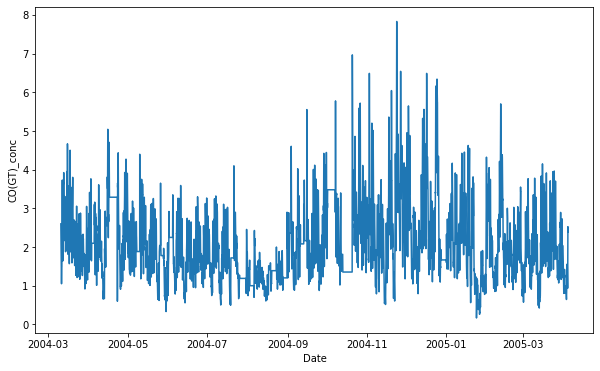

In [130]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.xlabel('Date')
plt.ylabel('CO(GT)_conc')
plt.plot(df_1)

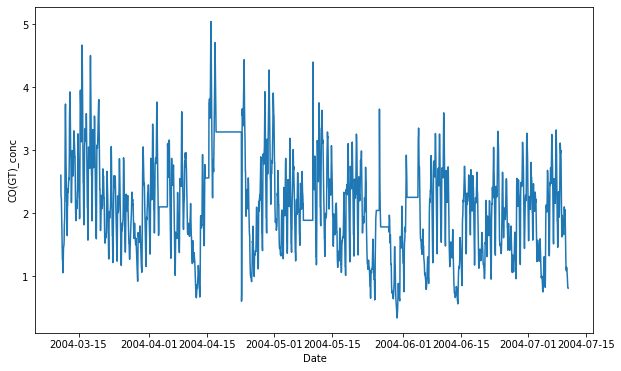

In [131]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.xlabel('Date')
plt.ylabel('CO(GT)_conc')
plt.plot(df_1.loc['2004-03-10 18:00:00':'2004-07-10 18:00:00'])

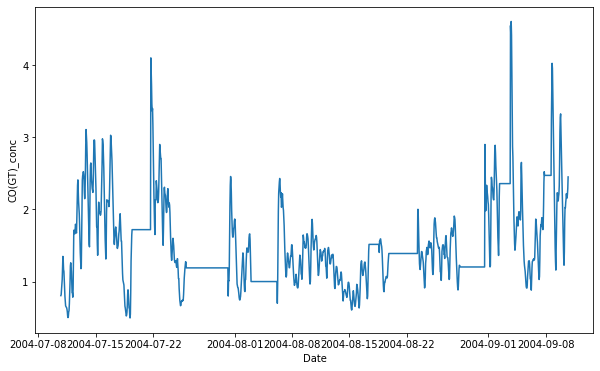

In [132]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.xlabel('Date')
plt.ylabel('CO(GT)_conc')
plt.plot(df_1.loc['2004-07-10 18:00:00':'2004-09-10 18:00:00'])

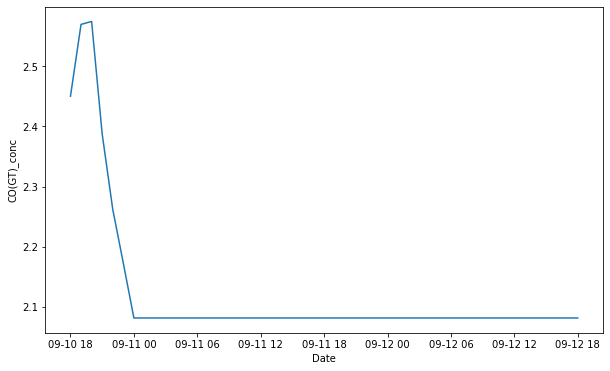

In [133]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.xlabel('Date')
plt.ylabel('CO(GT)_conc')
plt.plot(df_1.loc['2004-09-10 18:00:00':'2004-09-12 18:00:00'])

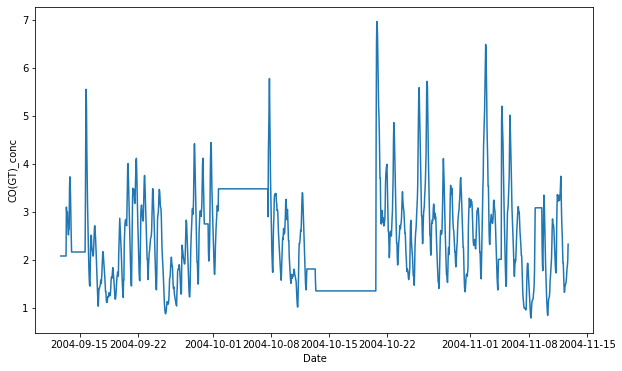

In [134]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.xlabel('Date')
plt.ylabel('CO(GT)_conc')
plt.plot(df_1.loc['2004-09-12 18:00:00':'2004-11-12 18:00:00'])

In [136]:
df.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH', 'hour', 'year', 'month', 'day'],
      dtype='object')

In [137]:

# Create New DataFrame of Specific column by DataFrame.assign() method.
df_1 = pd.DataFrame().assign(COGT=df['CO(GT)'], PT08S1CO=df['PT08.S1(CO)'], PT08S2NMHC=df['PT08.S2(NMHC)'], T = df['T'], PT08S3NOx=df['PT08.S3(NOx)'])
print(df_1)


                         COGT     PT08S1CO   PT08S2NMHC          T  \
date                                                                 
2004-03-10 18:00:00  2.600000  1360.000000  1046.000000  13.600000   
2004-03-10 19:00:00  2.274072  1323.061474   996.567561  13.437036   
2004-03-10 20:00:00  2.245001  1354.042018   973.974355  12.833804   
2004-03-10 21:00:00  2.230682  1361.029206   965.709129  12.250275   
2004-03-10 22:00:00  2.057541  1336.588136   930.100254  11.961944   
...                       ...          ...          ...        ...   
2005-04-04 10:00:00  2.525947  1162.399015   914.134036  15.249635   
2005-04-04 11:00:00  2.504913  1162.494634   932.091415  16.689581   
2005-04-04 12:00:00  2.487530  1159.233864   952.919440  18.314095   
2005-04-04 13:00:00  2.423739  1134.376497   954.205086  19.902888   
2005-04-04 14:00:00  2.387111  1124.293069   968.969090  21.270720   

                       PT08S3NOx  
date                              
2004-03-10 18:00:00

In [138]:
df_1.isnull().sum()

COGT          0
PT08S1CO      0
PT08S2NMHC    0
T             0
PT08S3NOx     0
dtype: int64

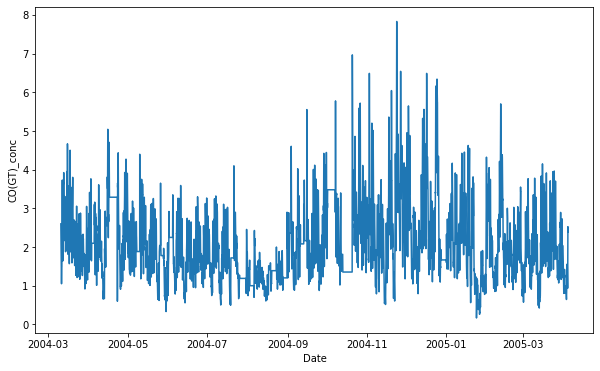

In [139]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.xlabel('Date')
plt.ylabel('CO(GT)_conc')
plt.plot(df_1['COGT'])

In [140]:
#df_1.interpolate(method='linear', axis=0, limit=40, inplace=True, limit_direction='both', limit_area=None, downcast=None)

In [141]:
#df_1.isnull().sum()

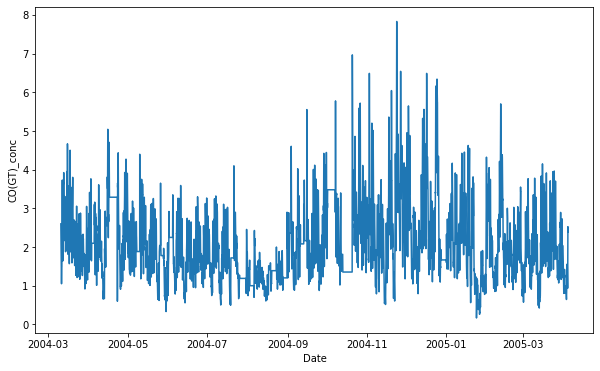

In [142]:
plt.xlabel('Date')
plt.ylabel('CO(GT)_conc')
plt.plot(df_1['COGT'])

In [143]:
#df_1.interpolate(method='linear', axis=0, limit=40, inplace=True, limit_direction='both', limit_area=None, downcast=None)

In [144]:
#df_1.isnull().sum()

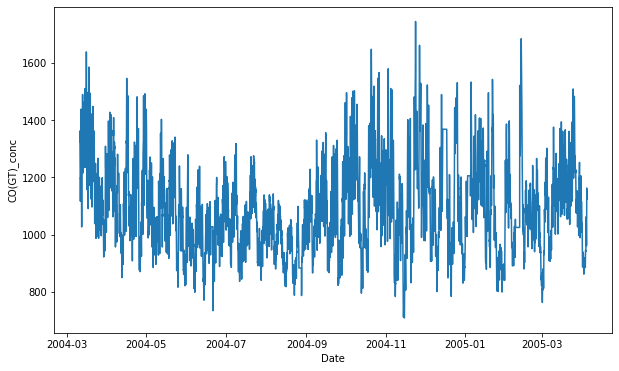

In [145]:
plt.xlabel('Date')
plt.ylabel('CO(GT)_conc')
plt.plot(df_1['PT08S1CO'])

In [146]:
rolmean = df_1['COGT'].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df_1['COGT'].rolling(window=12).std()
print(rolmean,rolstd)

date
2004-03-10 18:00:00         NaN
2004-03-10 19:00:00         NaN
2004-03-10 20:00:00         NaN
2004-03-10 21:00:00         NaN
2004-03-10 22:00:00         NaN
                         ...   
2005-04-04 10:00:00    1.485877
2005-04-04 11:00:00    1.569729
2005-04-04 12:00:00    1.660070
2005-04-04 13:00:00    1.755747
2005-04-04 14:00:00    1.858656
Name: COGT, Length: 9357, dtype: float64 date
2004-03-10 18:00:00         NaN
2004-03-10 19:00:00         NaN
2004-03-10 20:00:00         NaN
2004-03-10 21:00:00         NaN
2004-03-10 22:00:00         NaN
                         ...   
2005-04-04 10:00:00    0.561283
2005-04-04 11:00:00    0.633843
2005-04-04 12:00:00    0.683314
2005-04-04 13:00:00    0.704636
2005-04-04 14:00:00    0.698629
Name: COGT, Length: 9357, dtype: float64


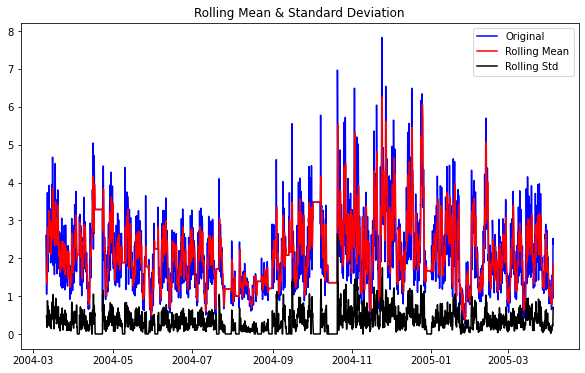

In [147]:
orig = plt.plot(df_1['COGT'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [149]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_1['COGT'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -9.846946e+00
p-value                        4.592785e-17
#Lags Used                     2.800000e+01
Number of Observations Used    9.328000e+03
Critical Value (1%)           -3.431051e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [150]:
train_data = df_1[:len(df)-720]
test_data = df_1[len(df)-720:] 
print(train_data)

                         COGT     PT08S1CO   PT08S2NMHC          T  \
date                                                                 
2004-03-10 18:00:00  2.600000  1360.000000  1046.000000  13.600000   
2004-03-10 19:00:00  2.274072  1323.061474   996.567561  13.437036   
2004-03-10 20:00:00  2.245001  1354.042018   973.974355  12.833804   
2004-03-10 21:00:00  2.230682  1361.029206   965.709129  12.250275   
2004-03-10 22:00:00  2.057541  1336.588136   930.100254  11.961944   
...                       ...          ...          ...        ...   
2005-03-05 10:00:00  1.676540  1024.270121   784.650977   6.361543   
2005-03-05 11:00:00  1.580256  1016.908379   782.638161   7.417745   
2005-03-05 12:00:00  1.566958  1009.126881   781.741109   8.465005   
2005-03-05 13:00:00  1.572397  1008.947590   791.487618   9.234270   
2005-03-05 14:00:00  1.675140  1011.501586   810.820674   9.897053   

                       PT08S3NOx  
date                              
2004-03-10 18:00:00

In [151]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries['COGT'].rolling(window=12).mean()
    movingSTD = timeseries['COGT'].rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries['COGT'], color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['COGT'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

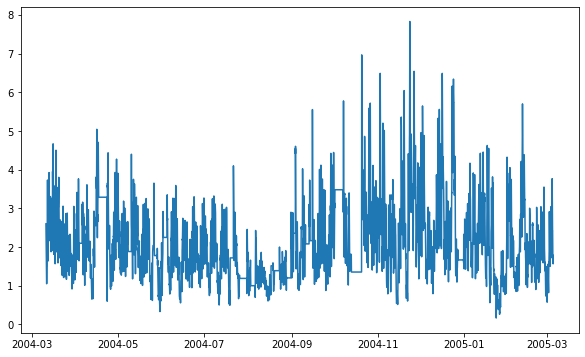

In [152]:
#df_log = np.log(train_data)
plt.plot(train_data['COGT'])

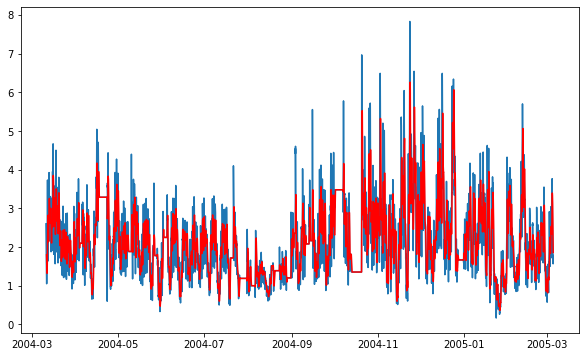

In [154]:
movingAverage = train_data['COGT'].rolling(window=12).mean()
movingSTD = train_data['COGT'].rolling(window=12).std()
plt.plot(train_data['COGT'])
plt.plot(movingAverage, color='red')

C:\Users\abulf\AppData\Local\Temp\ipykernel_14228\1058669970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['COGT'].dropna(inplace=True)


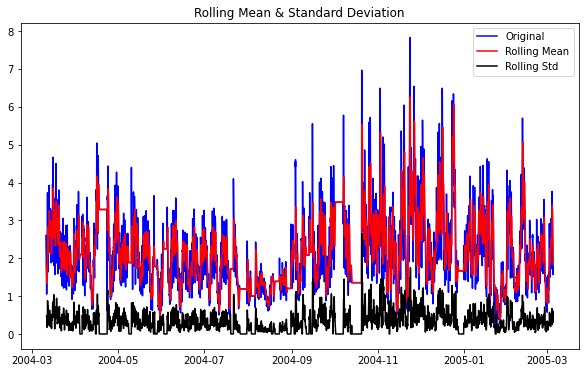

Results of Dickey Fuller Test:
Test Statistic                -9.386617e+00
p-value                        6.732453e-16
#Lags Used                     2.600000e+01
Number of Observations Used    8.610000e+03
Critical Value (1%)           -3.431110e+00
Critical Value (5%)           -2.861876e+00
Critical Value (10%)          -2.566949e+00
dtype: float64


In [155]:
train_data['COGT'].dropna(inplace=True)
test_stationarity(train_data)

                         COGT
date                         
2004-03-11 06:00:00 -0.049985
2004-03-11 07:00:00 -0.111150
2004-03-11 08:00:00 -0.163367
2004-03-11 09:00:00 -0.226350
2004-03-11 10:00:00 -0.313762
...                       ...
2005-03-04 22:00:00 -0.027967
2005-03-04 23:00:00 -0.094436
2005-03-05 00:00:00 -0.061603
2005-03-05 01:00:00  0.004675
2005-03-05 02:00:00  0.055524

[8613 rows x 1 columns]


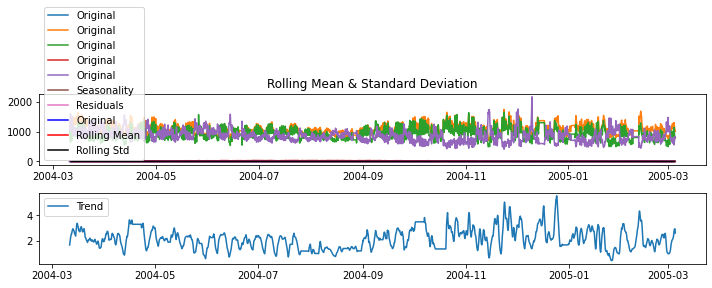

Results of Dickey Fuller Test:
Test Statistic                  -23.967456
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    8576.000000
Critical Value (1%)              -3.431113
Critical Value (5%)              -2.861877
Critical Value (10%)             -2.566949
dtype: float64


In [156]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_data['COGT']) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_data, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()



#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData = pd.DataFrame(decomposedLogData)
decomposedLogData.dropna(inplace=True)
decomposedLogData.rename(columns = {'resid' : 'COGT'}, inplace = True)
print(decomposedLogData)
test_stationarity(decomposedLogData)

                         COGT
date                         
2004-03-11 06:00:00 -0.049985
2004-03-11 07:00:00 -0.111150
2004-03-11 08:00:00 -0.163367
2004-03-11 09:00:00 -0.226350
2004-03-11 10:00:00 -0.313762
...                       ...
2005-03-04 22:00:00 -0.027967
2005-03-04 23:00:00 -0.094436
2005-03-05 00:00:00 -0.061603
2005-03-05 01:00:00  0.004675
2005-03-05 02:00:00  0.055524

[8613 rows x 1 columns]


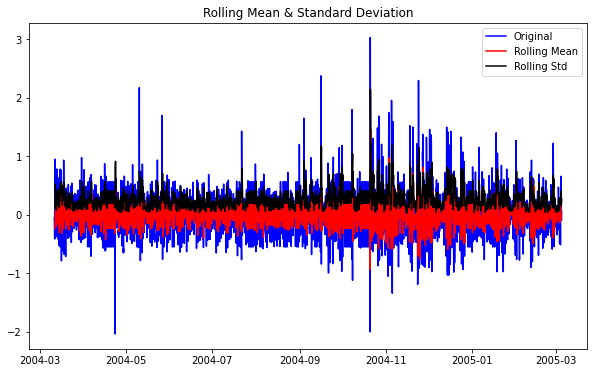

Results of Dickey Fuller Test:
Test Statistic                  -23.967456
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    8576.000000
Critical Value (1%)              -3.431113
Critical Value (5%)              -2.861877
Critical Value (10%)             -2.566949
dtype: float64


In [157]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
decomposedLogData = pd.DataFrame(decomposedLogData)
decomposedLogData.rename(columns = {'resid' : 'COGT'}, inplace = True)
print(decomposedLogData)
test_stationarity(decomposedLogData)

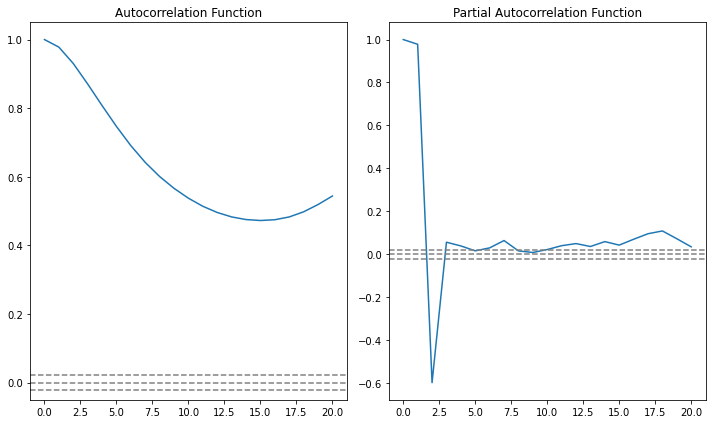

In [158]:
#ACF & PACF plots
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_data['COGT'], nlags=20)
lag_pacf = pacf(train_data['COGT'], nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_data['COGT'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_data['COGT'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_data['COGT'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_data['COGT'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()    

In [159]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


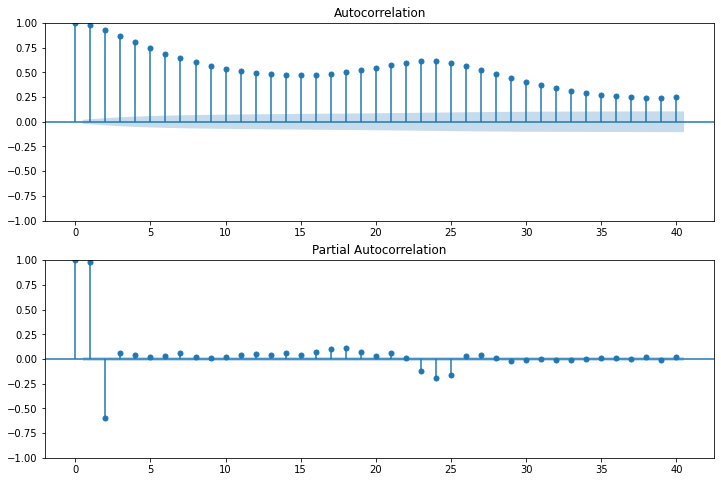

In [160]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_data['COGT'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_data['COGT'].iloc[13:],lags=40,ax=ax2)

In [161]:
train_data

,COGT,PT08S1CO,PT08S2NMHC,T,PT08S3NOx
date,,,,,
2004-03-10 18:00:00,2.600000,1360.000000,1046.000000,13.600000,1056.000000
2004-03-10 19:00:00,2.274072,1323.061474,996.567561,13.437036,1120.099207
2004-03-10 20:00:00,2.245001,1354.042018,973.974355,12.833804,1127.909555
2004-03-10 21:00:00,2.230682,1361.029206,965.709129,12.250275,1116.482877
2004-03-10 22:00:00,2.057541,1336.588136,930.100254,11.961944,1140.783366
...,...,...,...,...,...
2005-03-05 10:00:00,1.676540,1024.270121,784.650977,6.361543,825.083761
2005-03-05 11:00:00,1.580256,1016.908379,782.638161,7.417745,832.230095
2005-03-05 12:00:00,1.566958,1009.126881,781.741109,8.465005,831.875279


c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Plotting ARIMA model


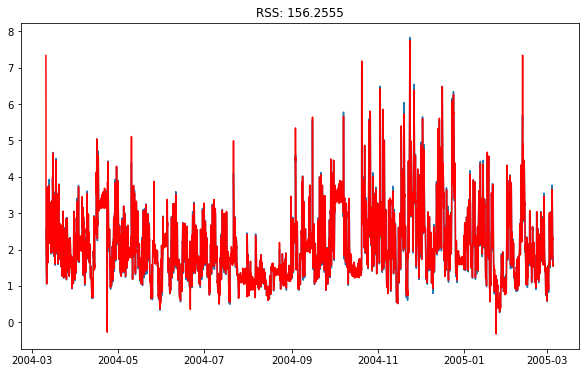

In [164]:
from statsmodels.tsa.arima.model import ARIMA
# AR+I+MA = ARIMA model
model = ARIMA(train_data['COGT'], exog=train_data[['PT08S1CO','PT08S2NMHC','T','PT08S3NOx']], order=(3,1,8))
results_ARIMA = model.fit()
plt.plot(train_data['COGT'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - train_data['COGT'])**2))
print('Plotting ARIMA model')

In [176]:
x=results_ARIMA.forecast(steps=720, exog=test_data[['PT08S1CO','PT08S2NMHC','T','PT08S3NOx']])
print(x)
x = pd.DataFrame(x)
print(x)


2005-03-05 15:00:00    1.688811
2005-03-05 16:00:00    1.727472
2005-03-05 17:00:00    1.809635
2005-03-05 18:00:00    1.867492
2005-03-05 19:00:00    1.954172
                         ...   
2005-04-04 10:00:00    2.287118
2005-04-04 11:00:00    2.316178
2005-04-04 12:00:00    2.347852
2005-04-04 13:00:00    2.288886
2005-04-04 14:00:00    2.298561
Freq: H, Name: predicted_mean, Length: 720, dtype: float64
                     predicted_mean
2005-03-05 15:00:00        1.688811
2005-03-05 16:00:00        1.727472
2005-03-05 17:00:00        1.809635
2005-03-05 18:00:00        1.867492
2005-03-05 19:00:00        1.954172
...                             ...
2005-04-04 10:00:00        2.287118
2005-04-04 11:00:00        2.316178
2005-04-04 12:00:00        2.347852
2005-04-04 13:00:00        2.288886
2005-04-04 14:00:00        2.298561

[720 rows x 1 columns]


In [177]:
x.rename(columns = {'predicted_mean' : 'COGT'}, inplace = True)
print(x)

                         COGT
2005-03-05 15:00:00  1.688811
2005-03-05 16:00:00  1.727472
2005-03-05 17:00:00  1.809635
2005-03-05 18:00:00  1.867492
2005-03-05 19:00:00  1.954172
...                       ...
2005-04-04 10:00:00  2.287118
2005-04-04 11:00:00  2.316178
2005-04-04 12:00:00  2.347852
2005-04-04 13:00:00  2.288886
2005-04-04 14:00:00  2.298561

[720 rows x 1 columns]


In [169]:
predictions_ARIMA = x
print(predictions_ARIMA.head())

                         COGT
2005-03-05 15:00:00  1.688811
2005-03-05 16:00:00  1.727472
2005-03-05 17:00:00  1.809635
2005-03-05 18:00:00  1.867492
2005-03-05 19:00:00  1.954172


In [170]:
print(test_data.head())

                         COGT     PT08S1CO  PT08S2NMHC          T   PT08S3NOx
date                                                                         
2005-03-05 15:00:00  1.646600  1006.966881  810.053687  10.470295  810.504672
2005-03-05 16:00:00  1.671502  1008.722290  819.273154  10.872780  801.037265
2005-03-05 17:00:00  1.724656  1023.404005  834.662742  10.988483  788.303050
2005-03-05 18:00:00  1.752952  1038.136359  843.148891  10.608467  773.458200
2005-03-05 19:00:00  1.873232  1057.684405  859.353767  10.273002  754.451972


In [171]:
y = test_data['COGT']
Y = predictions_ARIMA['COGT']
y_true, Y_pred = np.array(y), np.array(Y)
mape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100
print(mape)

21.412370526863686


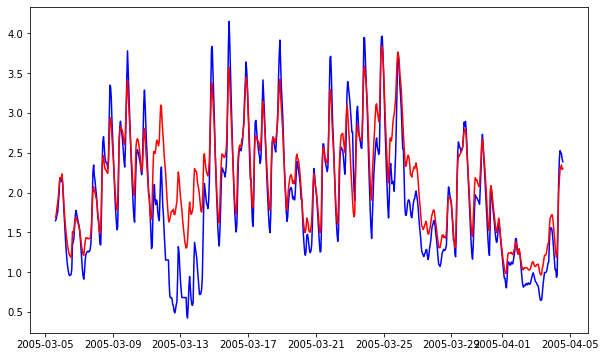

In [172]:
orig = plt.plot(test_data['COGT'], color='blue', label='Original')
predicted = plt.plot(predictions_ARIMA['COGT'], color='red', label='Predicted')
plt.show(block=False)

In [173]:
test_data.tail(10)

,COGT,PT08S1CO,PT08S2NMHC,T,PT08S3NOx
date,,,,,
2005-04-04 05:00:00,0.934715,961.314282,629.594001,14.598957,926.574234
2005-04-04 06:00:00,0.964346,972.401529,645.568956,13.787695,900.071676
2005-04-04 07:00:00,1.497796,1037.888321,737.122098,13.137328,831.645731
2005-04-04 08:00:00,2.103168,1102.820352,836.542412,13.195030,765.355902
2005-04-04 09:00:00,2.409545,1133.715030,878.777666,13.991339,724.250552
2005-04-04 10:00:00,2.525947,1162.399015,914.134036,15.249635,694.776525
2005-04-04 11:00:00,2.504913,1162.494634,932.091415,16.689581,680.333654
2005-04-04 12:00:00,2.487530,1159.233864,952.919440,18.314095,668.029593
2005-04-04 13:00:00,2.423739,1134.376497,954.205086,19.902888,673.434406


In [174]:
predictions_ARIMA.tail()

,COGT
2005-04-04 10:00:00,2.287118
2005-04-04 11:00:00,2.316178
2005-04-04 12:00:00,2.347852
2005-04-04 13:00:00,2.288886
2005-04-04 14:00:00,2.298561


In [137]:
model = auto_arima(df_log['COGT'], start_p=0, start_q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8637
Model:               SARIMAX(5, 1, 4)   Log Likelihood                9818.195
Date:                Wed, 10 Aug 2022   AIC                         -19616.390
Time:                        11:45:38   BIC                         -19545.753
Sample:                             0   HQIC                        -19592.305
                               - 8637                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6036      0.139      4.328      0.000       0.330       0.877
ar.L2         -0.2187      0.210     -1.042      0.297      -0.630       0.193
ar.L3          0.1049      0.214      0.490      0.624      -0.314       0.524
ar.L4          0.6503      0.190      3.424      0.001       0.278       1.023
ar.L5         -0.4470      0.075     -5.985      0.000      -0.593      -0.301
ma.L1         -0.0489      0.139     -0.350      0.726      -0.322       0.224
ma.L2          0.0864      0.133      0.648      0.517      -0.175       0.347
ma.L3         -0.0949      0.126     -0.751      0.453      -0.343       0.153
ma.L4         -0.7420      0.113     -6.589      0.000      -0.963      -0.521
sigma2         0.0060   1.45e-05    417.121      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):           4211174.70
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.73
Prob(H) (two-sided):                  0.01   Kurtosis:                       111.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

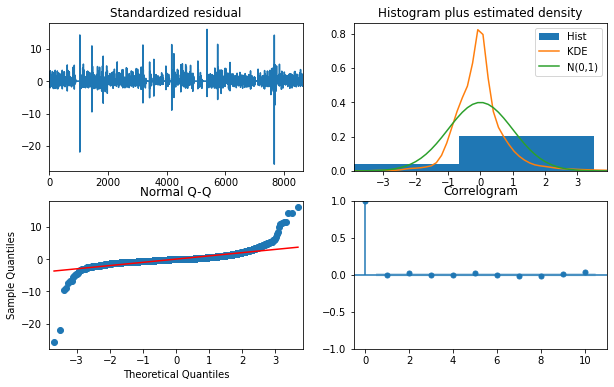

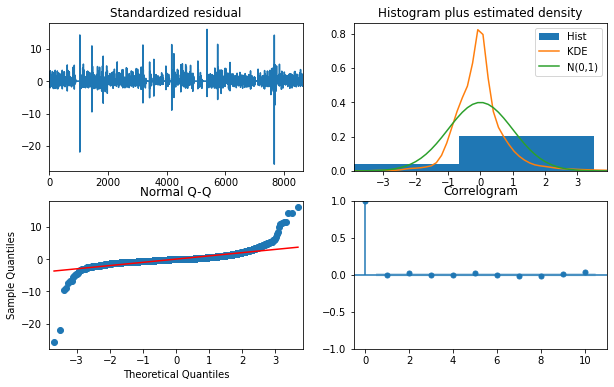

In [138]:
model.plot_diagnostics()

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Plotting ARIMA model


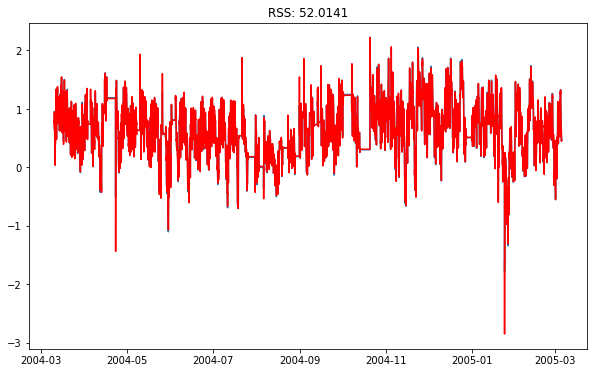

In [143]:
from statsmodels.tsa.arima.model import ARIMA
# AR+I+MA = ARIMA model
model = ARIMA(df_log['COGT'], order=(5,0,4))
results_ARIMA = model.fit()
plt.plot(df_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_log['COGT'])**2))
print('Plotting ARIMA model')

In [144]:
x=results_ARIMA.forecast(steps=720)
print(x)
x = pd.DataFrame(x)
print(x)
x.rename(columns = {'predicted_mean' : 'COGT'}, inplace = True)
print(x)

2005-03-05 15:00:00    0.563125
2005-03-05 16:00:00    0.602859
2005-03-05 17:00:00    0.635771
2005-03-05 18:00:00    0.659235
2005-03-05 19:00:00    0.672736
                         ...   
2005-04-04 10:00:00    0.663750
2005-04-04 11:00:00    0.663750
2005-04-04 12:00:00    0.663750
2005-04-04 13:00:00    0.663750
2005-04-04 14:00:00    0.663750
Freq: H, Name: predicted_mean, Length: 720, dtype: float64
                     predicted_mean
2005-03-05 15:00:00        0.563125
2005-03-05 16:00:00        0.602859
2005-03-05 17:00:00        0.635771
2005-03-05 18:00:00        0.659235
2005-03-05 19:00:00        0.672736
...                             ...
2005-04-04 10:00:00        0.663750
2005-04-04 11:00:00        0.663750
2005-04-04 12:00:00        0.663750
2005-04-04 13:00:00        0.663750
2005-04-04 14:00:00        0.663750

[720 rows x 1 columns]
                         COGT
2005-03-05 15:00:00  0.563125
2005-03-05 16:00:00  0.602859
2005-03-05 17:00:00  0.635771
2005-03-05 18

In [145]:
predictions_ARIMA = np.exp(x)
print(predictions_ARIMA.head())
y = test_data['COGT']
Y = predictions_ARIMA['COGT']
y_true, Y_pred = np.array(y), np.array(Y)
mape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100
print(mape)

                         COGT
2005-03-05 15:00:00  1.756152
2005-03-05 16:00:00  1.827335
2005-03-05 17:00:00  1.888478
2005-03-05 18:00:00  1.933313
2005-03-05 19:00:00  1.959592
43.80835655118594


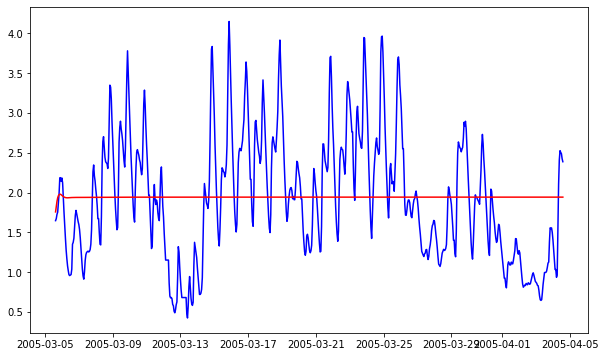

In [146]:
orig = plt.plot(test_data['COGT'], color='blue', label='Original')
predicted = plt.plot(predictions_ARIMA['COGT'], color='red', label='Predicted')
plt.show(block=False)

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting SARIMA model


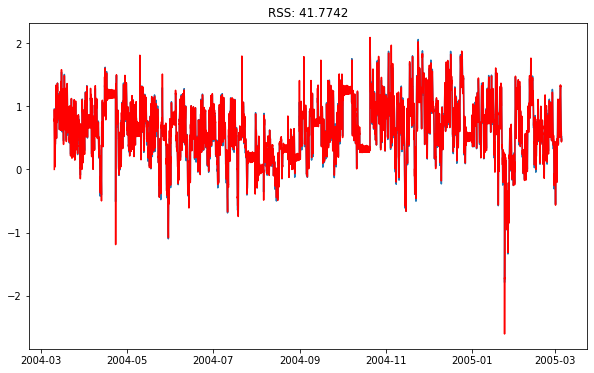

In [147]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_log['COGT'], order=(5,0,4),seasonal_order=(5,0,4,24))
results_SARIMA = model.fit()
plt.plot(df_log)
plt.plot(results_SARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_SARIMA.fittedvalues - df_log['COGT'])**2))
print('Plotting SARIMA model')

In [148]:
x=results_SARIMA.forecast(steps=720)
print(x)
x = pd.DataFrame(x)
print(x)
x.rename(columns = {'predicted_mean' : 'COGT'}, inplace = True)
print(x)

2005-03-05 15:00:00    0.537043
2005-03-05 16:00:00    0.566733
2005-03-05 17:00:00    0.594772
2005-03-05 18:00:00    0.659337
2005-03-05 19:00:00    0.747915
                         ...   
2005-04-04 10:00:00    0.506860
2005-04-04 11:00:00    0.512260
2005-04-04 12:00:00    0.504744
2005-04-04 13:00:00    0.502494
2005-04-04 14:00:00    0.513548
Freq: H, Name: predicted_mean, Length: 720, dtype: float64
                     predicted_mean
2005-03-05 15:00:00        0.537043
2005-03-05 16:00:00        0.566733
2005-03-05 17:00:00        0.594772
2005-03-05 18:00:00        0.659337
2005-03-05 19:00:00        0.747915
...                             ...
2005-04-04 10:00:00        0.506860
2005-04-04 11:00:00        0.512260
2005-04-04 12:00:00        0.504744
2005-04-04 13:00:00        0.502494
2005-04-04 14:00:00        0.513548

[720 rows x 1 columns]
                         COGT
2005-03-05 15:00:00  0.537043
2005-03-05 16:00:00  0.566733
2005-03-05 17:00:00  0.594772
2005-03-05 18

In [149]:
predictions_SARIMA = np.exp(x)
print(predictions_SARIMA.head())

                         COGT
2005-03-05 15:00:00  1.710941
2005-03-05 16:00:00  1.762500
2005-03-05 17:00:00  1.812618
2005-03-05 18:00:00  1.933510
2005-03-05 19:00:00  2.112590


In [150]:
y = test_data['COGT']
Y = predictions_SARIMA['COGT']
y_true, Y_pred = np.array(y), np.array(Y)
mape = np.mean(np.abs((y_true - Y_pred) / y_true)) * 100
print(mape)

37.40975520191709


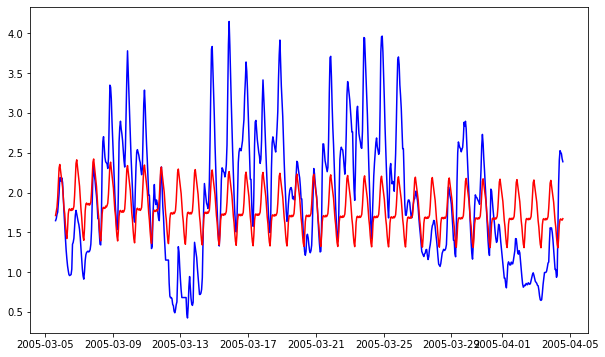

In [151]:
orig = plt.plot(test_data['COGT'], color='blue', label='Original')
predicted = plt.plot(predictions_SARIMA['COGT'], color='red', label='Predicted')
plt.show(block=False)